# Imports

In [18]:
# Torch
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms,models
import torch.optim as optim
from torch.autograd import Variable

# Time
import time
import copy

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Seeding
torch.manual_seed(24)

# Scheduler
from torch.optim import lr_scheduler

# GPU/CPU

In [3]:
# Get device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
device

'cuda:0'

# Datasets

### Helpers

In [5]:
# Imports
import os
import numpy as np

def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if torch.cuda.is_available():
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

### Load

In [6]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder("./dataset/train/", transform=transform)

In [7]:
# Labels
class_names = dataset.classes

In [8]:
class_names

['norobot', 'robot']

In [30]:
# Create train and val
batch_size = 32
val_size = int(0.25 * len(dataset))
train_size = len(dataset) - val_size

# Create train and validation
trainset, validationset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [31]:
print(len(trainset), len(validationset))

1489 496


### DataLoaders

In [32]:
# Loaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True,)
validation_loader = torch.utils.data.DataLoader(validationset, batch_size, shuffle=True)

In [33]:
# Move dataloaders as dict
dataloaders = {'train': train_loader, 'val': validation_loader}

### Visualize Images

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
        1, 1, 0, 0, 1, 1, 0, 1])


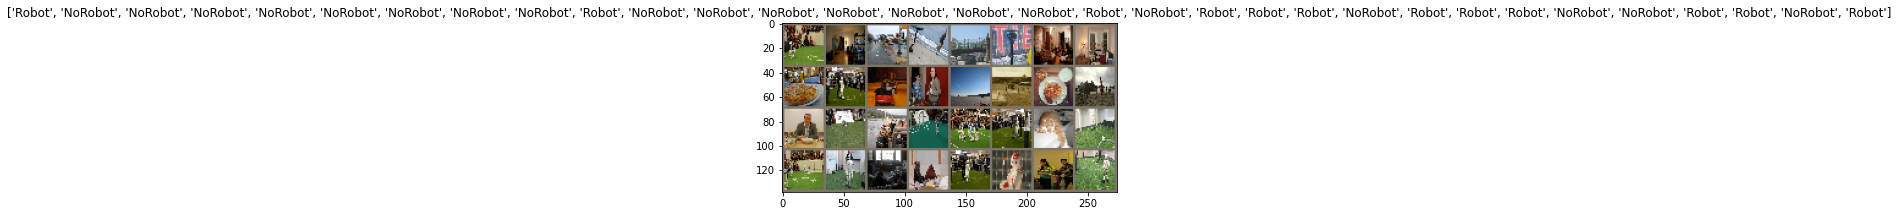

In [34]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))
print(classes)

class_names = {0: "NoRobot", 1: "Robot"}

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

title=[class_names[x.item()] for x in classes]

imshow(out, title)

# Training

In [38]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            if phase=="train":
                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    #inputs, targets_a, targets_b, lam = mixup_data(inputs, labels)
                    #inputs, targets_a, targets_b = map(Variable, (inputs,targets_a, targets_b))

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        #loss = mixup_criterion(criterion, outputs,targets_a, targets_b, lam)

                        _, preds = torch.max(outputs, 1)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
#                             scheduler.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
            if phase=="val":
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    #inputs, targets_a, targets_b, lam = mixup_data(inputs, labels)
                    #inputs, targets_a, targets_b = map(Variable, (inputs,targets_a, targets_b))

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        #loss = mixup_criterion(criterion, outputs,targets_a, targets_b, lam)

                        _, preds = torch.max(outputs, 1)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

# Pre-trained densenet

In [39]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False


# Initialize the model for this run
model_ft = models.densenet121(pretrained=True)
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 2)

# Send the model to GPU
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()

# Fine-Tuning

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler,  num_epochs=20)

Epoch 0/19
----------
train Loss: 0.3986 Acc: 0.8126
val Loss: 0.2131 Acc: 0.9395

Epoch 1/19
----------
train Loss: 0.1420 Acc: 0.9537
val Loss: 0.1387 Acc: 0.9637

Epoch 2/19
----------
train Loss: 0.0896 Acc: 0.9725
val Loss: 0.1037 Acc: 0.9738

Epoch 3/19
----------
train Loss: 0.0388 Acc: 0.9906
val Loss: 0.0907 Acc: 0.9677

Epoch 4/19
----------
train Loss: 0.0458 Acc: 0.9872
val Loss: 0.0910 Acc: 0.9819

Epoch 5/19
----------
train Loss: 0.0394 Acc: 0.9906
val Loss: 0.0754 Acc: 0.9819

Epoch 6/19
----------
train Loss: 0.0271 Acc: 0.9913
val Loss: 0.0671 Acc: 0.9839

Epoch 7/19
----------
train Loss: 0.0217 Acc: 0.9926
val Loss: 0.0754 Acc: 0.9778

Epoch 8/19
----------
train Loss: 0.0225 Acc: 0.9973
val Loss: 0.0689 Acc: 0.9839

Epoch 9/19
----------
train Loss: 0.0104 Acc: 0.9987
val Loss: 0.0717 Acc: 0.9839

Epoch 10/19
----------
train Loss: 0.0066 Acc: 0.9980
val Loss: 0.0714 Acc: 0.9798

Epoch 11/19
----------
train Loss: 0.0091 Acc: 0.9973
val Loss: 0.0667 Acc: 0.9879

Ep